In [ ]:
from pyspark import SparkContext
from geopyspark.geopycontext import GeoPyContext
from geopyspark.geotrellis.catalog import read, read_value, query, write
from geopyspark.geotrellis.constants import SPATIAL, ZOOM, TILE, HEATMAP_YELLOW_TO_RED
from geopyspark.geotrellis.geotiff_rdd import get
from geopyspark.geotrellis.rdd import RasterRDD, TiledRasterRDD
from geopyspark.geotrellis.render import PngRDD, get_hex
from geonotebook.vis.geotrellis.render_methods import single_band_render_from_color_map
from geonotebook.wrappers import GeoTrellisCatalogLayerData, RddRasterData
from functools import reduce
import numpy as np

In [ ]:
M.set_center(-85.2934168635424, 35.02445474101138, 9)

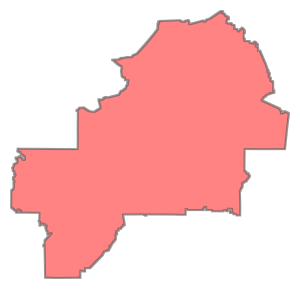

In [19]:
from functools import partial
import urllib
import json
import pyproj
from shapely.geometry import mapping, shape
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:3857'))

blob = urllib.request.urlopen("https://s3.amazonaws.com/chattademo/chatta_mask.json").read()
geom = shape(json.loads(blob.decode("utf-8")))
center = geom.centroid
chatta_poly = transform(project, geom)
chatta_poly

In [ ]:
!curl -o /tmp/mask.json https://s3.amazonaws.com/chattademo/chatta_mask.json

from geonotebook.wrappers import VectorData
vd = VectorData("/tmp/mask.json")
name = "Outline"
M.add_layer(vd, name=name)

In [ ]:
M.set_center(center.x, center.y, 9)

In [ ]:
M.remove_layer(M.layers[0])

## Viewing the layers

In [ ]:
catalog_uri = "file://catalog"
          

In [ ]:
sc = SparkContext(appName="Chatta Weighted Overlay")
geopysc = GeoPyContext(sc)

### NLCD cultivated land vs Chattanooga prime agriculture soil

In [ ]:
nlcdCultivated = GeoTrellisCatalogLayerData(geopysc, 
                                            catalog_uri, 
                                            "cultivated-land-cover",
                                            SPATIAL)

agSoil = GeoTrellisCatalogLayerData(geopysc, 
                                    catalog_uri, 
                                    "prime-ag-soil",
                                    SPATIAL)

In [ ]:

cmap1 = { 0 : "#00000099", 1: "#CA9146FF" }
cmap_render1 = single_band_render_from_color_map(cmap1)
def render_nlcd_cultivated(tile):
    arr = tile[0]
    print("%d - %d" % (arr.min(), arr.max()))
    return cmap_render1(arr)

cmap2 = { 0 : "#00000099", 1: "#CAC145FF", 1: "#FFFF45FF", 128: "#FF000099" }
cmap_render2 = single_band_render_from_color_map(cmap2)
def render_ag_soil(tile):
    t = tile[0]
    arr = np.ma.masked_where(t == 128, t)
    return cmap_render2(arr)

In [ ]:

#M.add_layer(nlcdCultivated, render_tile=render_nlcd_cultivated)
M.add_layer(agSoil, render_tile=render_ag_soil)

In [ ]:
#M.layers
M.remove_layer(M.layers[0])
#M.remove_layer(M.layers[0])

In [ ]:
nlcd_cultivated_rdd =    query(geopysc, 
                               SPATIAL, 
                               catalog_uri, 
                               "cultivated-land-cover", 
                               12, 
                               intersects=chatta_poly)
ag_soil_rdd =    query(geopysc, 
                       SPATIAL, 
                       catalog_uri, 
                       "prime-ag-soil", 
                       12, 
                       intersects=chatta_poly)

In [ ]:
nlcd = nlcd_cultivated_rdd.to_numpy_rdd()
ag = ag_soil_rdd.to_numpy_rdd()

## How would I do the rest of this?
## I want to combine the numpy arrays and show
## prime ag soil that NLCD says isn't being cultivated.

## The Weighted Overlay

In [ ]:
layer_weights = { "developed-land" :-3,
                  "prime-ag-soil" : -1,
                  "not-prime-ag-soil" : 4,
                  "forested-lands" : 2,
                  #"cultivated-land-cover" : 3,
                  #"forest-land-cover" : 1,
                  "impervious" : -2,
                  "protected" : 4,
                  "prime-ag-soil-notfarm" : 3,
                  "private-with-easements" : -2,
                  "public-working-lands" : 5,
                  "wetlands" : 2
                }
# layer_weights = { "developed-land" : 1,
#                   "prime-ag-soil" : 1,
#                   "not-prime-ag-soil" : 1,
#                   "forested-lands" : 1,
#                   #"cultivated-land-cover" : 3,
#                   #"forest-land-cover" : 1,
#                   "impervious" : 1,
#                   "protected" : 1,
#                   "prime-ag-soil-notfarm" : 1,
#                   "private-with-easements" : 1,
#                   "public-working-lands" : 1,
#                   "wetlands" : 1
#                 }
layers = list(layer_weights.keys())

In [ ]:
from pyspark.storagelevel import StorageLevel
WO_ZOOM = 9
rdds = []
for layer_name in layer_weights:
    rdd = query(geopysc, 
                SPATIAL, 
                catalog_uri, 
                layer_name, WO_ZOOM, 
                intersects=chatta_poly,
                numPartitions=32).persist(StorageLevel.MEMORY_AND_DISK_SER)
    weighted = rdd * layer_weights[layer_name]
    fixed = (weighted + []) / 4.0
    rdds.append(fixed)

weighted_overlay = rdds[0] + rdds[1:]    

In [ ]:
breaks = weighted_overlay.get_quantile_breaks_exact_int(20)
#breaks = [0,1,2,3,4,5]
print(breaks)

In [ ]:
colors = get_hex(geopysc, HEATMAP_YELLOW_TO_RED, len(breaks))
#colors = list(geopysc._jvm.geopyspark.geotrellis.ColorRamp.get_hex(HEATMAP_YELLOW_TO_RED, len(breaks)))
print(colors)
reversed(list(enumerate(zip(breaks[:-1],breaks[1:]))))

In [ ]:
color_dict = dict(enumerate(colors))
color_dict.update({ -1 : "#00000000"})
cmap = single_band_render_from_color_map(color_dict)
def render_wo_tile(tiles):
    weighted = []
    minmaxs = []
    for i, tile in enumerate(tiles):
        t = tile[0].astype('int8')
        w = np.ma.masked_where(t == -128, t) * layer_weights[layers[i]]
        weighted.append(w)
        minmaxs.append((w.min(), w.max()))
        
    #print(minmaxs)
    tile = reduce(lambda x,y: x + y, weighted)
    print("%d - %d" % (tile.min(), tile.max()))
    for (i, (low, high)) in reversed(list(enumerate(zip(breaks[:-1],breaks[1:])))):
        if i == 0:
            tile[np.ma.where((-127 <= tile) & (tile < high))] = i
        elif i < len(breaks) - 1:
            tile[np.ma.where((low <= tile) & (tile < high))] = i
        else:
            tile[np.ma.where(low <= tile)] = i
    tile[np.ma.where(tile == -128)] = -1
    print("%d - %d" % (tile.min(), tile.max()))
    return cmap(tile)

    

In [ ]:
wo_data =GeoTrellisCatalogLayerData(geopysc, 
                                    catalog_uri, 
                                    layers,
                                    SPATIAL)

In [ ]:
if len(M.layers) > 0:
    M.remove_layer(M.layers[0])


In [ ]:
weighted_overlay.get_min_max()

In [ ]:
png = PngRDD.makePyramid(weighted_overlay, HEATMAP_YELLOW_TO_RED)
#png = PngRDD.makePyramid(rdd, HEATMAP_YELLOW_TO_RED)

In [ ]:
png.pngpyramid[0].rdd().partitioner().get().numPartitions()

In [ ]:
M.add_layer(RddRasterData(png))

In [ ]:
layouts = set([])
for rdd in rdds:
    tl = rdd.layer_metadata['layoutDefinition']["tileLayout"]
    layouts.add((tl['layoutCols'],tl['layoutRows'],tl['tileCols'],tl['tileRows']))

In [ ]:
t = read_value(geopysc, SPATIAL, catalog_uri, "prime-ag-soil", 10,266,405)

In [ ]:
(t['data']).max()

In [ ]:
(td[0] * 4).min()